In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
import backtrader as bt
import pyfolio as pf
import math
from utils import *
%matplotlib inline

In [2]:
train_length = 200
test_length = 10
return_day = 3

In [4]:
pred = pd.read_csv(f'pred/prediction_{train_length}_{test_length}_{return_day}.csv', index_col='Date', parse_dates=True)
pred.head()

,0
Dates,
2007-08-19,Neg
2007-08-26,Neg
2007-09-02,Neg
2007-09-09,Neg
2007-09-16,Neg


In [5]:
class TestStrategy(BaseStrategy):
    def __init__(self):
        self.buys = []
        self.sells = []
        self.last = None
        
    def canceled(self):
        if self.last == 'Pos':
            del self.buys[-1]
        elif self.last == 'Neg':
            del self.sells[-1]
        
    def next(self):
        date_to_look_for = self.data.datetime.datetime(0)
        try:
            predicted_dir = pred.loc[date_to_look_for].iloc[0]
        except:
            predicted_dir = None
        
        if predicted_dir == 'Pos':
            self.log('Long prediction')
            self.buy(exectype=bt.Order.Market)
            self.buys.append(self.data.datetime.datetime(return_day))
        if (len(self.buys) > 0) and (date_to_look_for >= self.buys[0]):
            self.log('Close long')
            self.sell(exectype=bt.Order.Market)
            del self.buys[0]
            print(f'\tBuys length changed to {len(self.buys)}')
            
#         if predicted_dir == 'Neg':
#             self.log('Short prediction')
#             self.sell(exectype=bt.Order.Market)
#             self.sells.append(self.data.datetime.datetime(return_day))
#         if (len(self.sells) > 0) and (date_to_look_for >= self.sells[0]):
#             self.log('Close short')
#             self.buy(exectype=bt.Order.Market)
#             del self.sells[0]
#             print(f'\tSells length changed to {len(self.buys)}')
            
        self.last = predicted_dir

In [6]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.PandasData(dataname=read_ami_SPY_data(), fromdate=pred.index[0])

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.SizerFix, stake=100)
# cerebro.addsizer(bt.sizers.PercentSizer, percents=1)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


In [7]:
# transactions

Entire data start date: 2007-08-20
Entire data end date: 2018-01-18
Backtest months: 124


C:\DEV\Anaconda3\envs\trading\lib\site-packages\empyrical\stats.py:522: RuntimeWarning: invalid value encountered in double_scalars
  sortino = mu / dsr
C:\DEV\Anaconda3\envs\trading\lib\site-packages\empyrical\stats.py:954: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%
Omega ratio,NaN
Sortino ratio,NaN
Skew,0.00


C:\DEV\Anaconda3\envs\trading\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2007-08-20,2007-08-20,2007-08-20,1
1,0.00,2007-08-20,2007-08-20,2007-08-20,1
2,0.00,2007-08-20,2007-08-20,2007-08-20,1
3,0.00,2007-08-20,2007-08-20,2007-08-20,1
4,0.00,2007-08-20,2007-08-20,2007-08-20,1


C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\plotting.py:819: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  bmark_vol = factor_returns.loc[returns.index].std()


KeyboardInterrupt: 

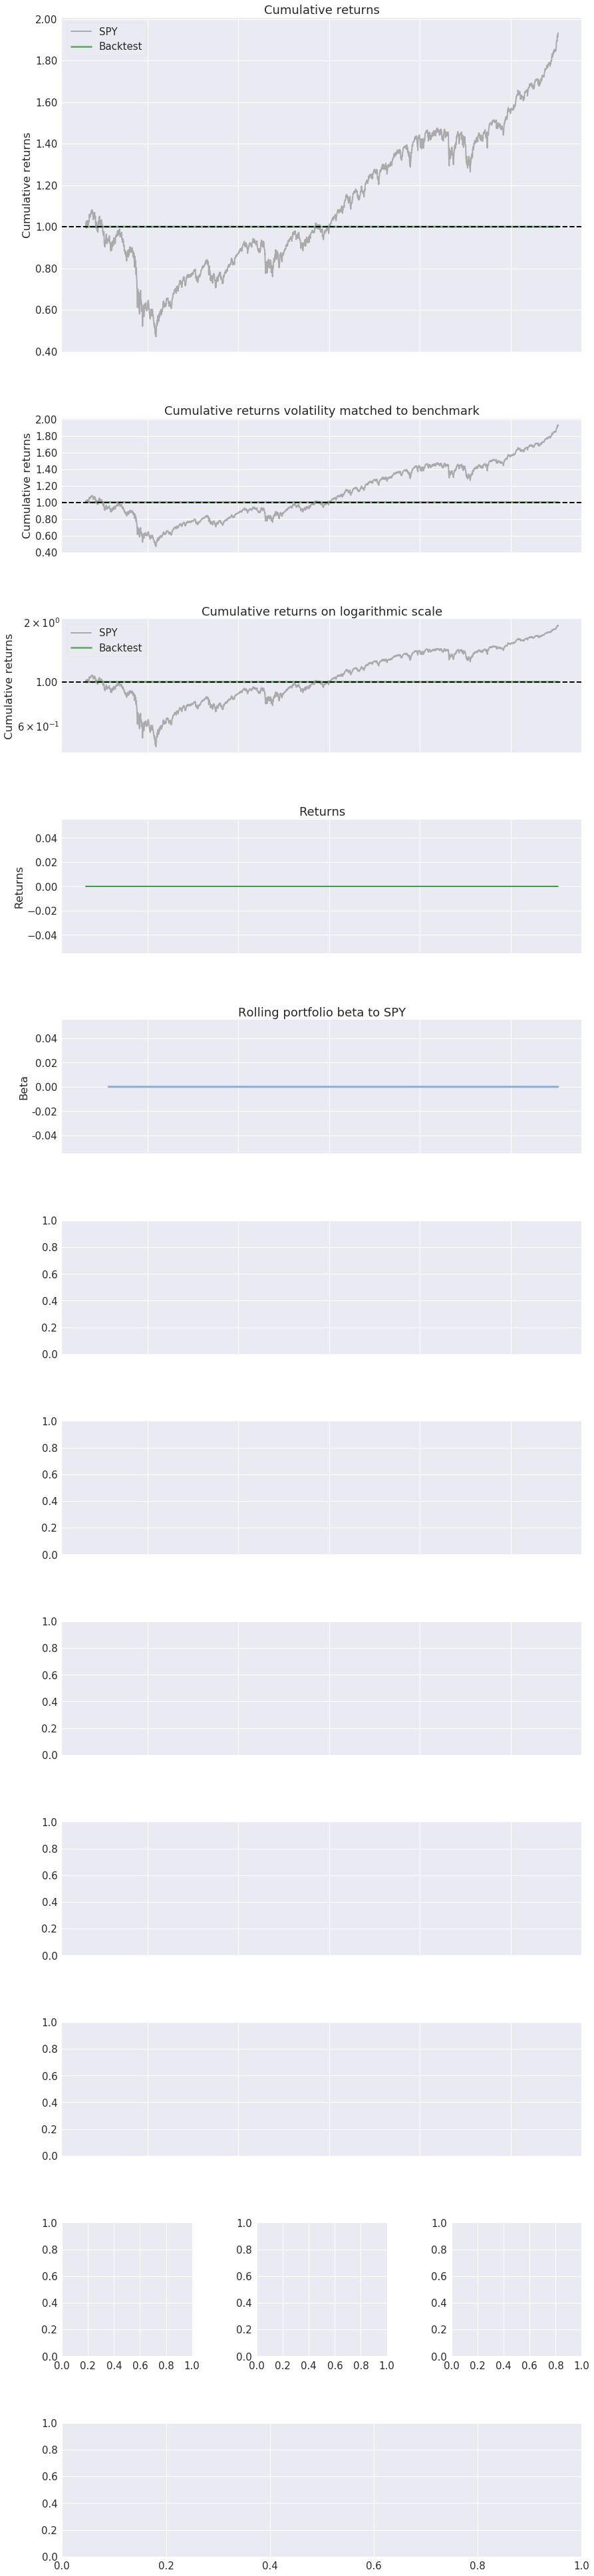

In [8]:
pf.create_full_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions,
                          round_trips=True)